In [16]:
!pip install tensorflow scikit-learn matplotlib pillow numpy


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array


In [18]:
img_size = (496, 248)
batch_size = 8
data_dir = "Data"

image_paths = []
labels = []
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_idx[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp, random_state=42
)

def preprocess_image(path, label):
    img = load_img(path.numpy().decode(), color_mode='grayscale', target_size=img_size)
    img = img_to_array(img) / 255.0
    return img, label

def tf_preprocess(path, label):
    img, label = tf.py_function(preprocess_image, [path, label], [tf.float32, tf.int64])
    img.set_shape((img_size[0], img_size[1], 1))
    label.set_shape(())
    return img, label

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42)
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

print("Classes:", class_names)
print("Treino:", len(X_train), "Validação:", len(X_val), "Teste:", len(X_test))

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Treino: 8399 Validação: 1801 Teste: 1800


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

In [20]:
from tensorflow.keras import layers, models

# Data augmentation direto no pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 1))
x = data_augmentation(inputs)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 496, 248, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 496, 248, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 496, 248, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 248, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 248, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 248, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 124, 62, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 124, 62, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 124, 62, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 62, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,583,364 (120.48 MB)

 Trainable params: 31,583,364 (120.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
)

Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 223s 203ms/step - accuracy: 0.3163 - loss: 1.4792 - val_accuracy: 0.5314 - val_loss: 0.9902
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 212s 202ms/step - accuracy: 0.4770 - loss: 1.1592 - val_accuracy: 0.5552 - val_loss: 0.9318
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 213s 202ms/step - accuracy: 0.4894 - loss: 1.1121 - val_accuracy: 0.5547 - val_loss: 0.9109
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 213s 203ms/step - accuracy: 0.5135 - loss: 1.0826 - val_accuracy: 0.6152 - val_loss: 0.8408
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 213s 203ms/step - accuracy: 0.5333 - loss: 1.0350 - val_accuracy: 0.5819 - val_loss: 0.8401
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 218s 207ms/step - accuracy: 0.5361 - loss: 1.0316 - val_accuracy: 0.6185 - val_loss: 0.8256
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 218s 208ms/step - accuracy: 0.5379 - loss: 1.0226 - val_accuracy: 0.5941 - val_loss: 0.8419
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 218s 208ms/step - ac

In [22]:
# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test_ds)
print(f"Acurácia no teste: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6848 - loss: 2.3710
Acurácia no teste: 0.6872


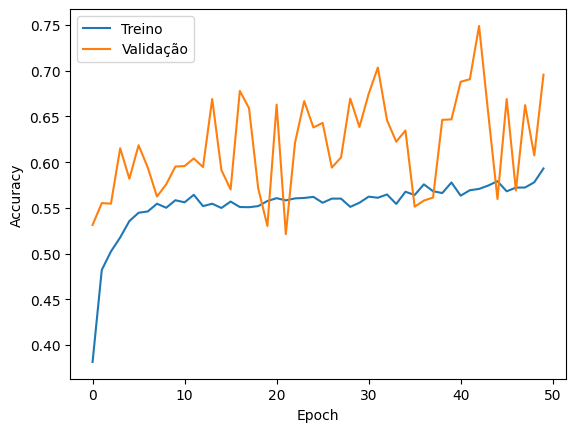

In [23]:
import matplotlib.pyplot as plt
# (Opcional) Visualizar as curvas de acurácia e perda
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()